<font size="6">Amazon Review Sentiment Classification</font>

I obtained a dataset of Amazon food reviews from Kaggle. The original dataset is available for download at https://www.kaggle.com/snap/amazon-fine-food-reviews/data.

In this jupyter notebook, I build a classifier to distinguish positive reviews from negative reviews. In this case, I defined positive to mean the reviewer assigned a score of 5 stars, and I defined negative to be any score of less than 5 stars. Since about 60% of the reviews were 5-star reviews, I took this to mean reviewers were usually quite willing to give 5 star reviews, and a score of less than 5 stars indicates some sort of unhappiness on the part of the reviewer. Thus, 5 stars is a positive review, and less than 5 stars is a negative review.

In [279]:
%matplotlib notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt



In [280]:
##We read in the data into a Pandas dataframe object
data = pd.read_csv("data/Reviews.csv")



##lets just take a subset of the data 
data = data.iloc[:150000, :]

##For our purposes, we will only need the columns Score, Summary, and Text.
##So we will drop the rest from our dataframe

features = ['Score', 'Summary', 'Text']
dropped_features = [f for f in data.columns if f not in features]
data.drop(dropped_features, axis = 1, inplace = True)


In [281]:
print(data.shape)

(150000, 3)


In [282]:
##Lets check for null features
for f in features:
    print(data[f].notnull().value_counts())
    print('\n')

True    150000
Name: Score, dtype: int64


True     149995
False         5
Name: Summary, dtype: int64


True    150000
Name: Text, dtype: int64




We see that 5 of the reviews were missing the entry for the Summary column.
We'll just remove the corresponding 26 rows from the dataframe.

In [283]:
data = data[data.Summary.notnull() == True]

We will need to do some basic preprocessing before we can look create features for a learning algorithm.
We will convert the raw scores to 1's to indicate a 5 star review and  0's to indicate a review where the score
was less than 5 stars. 

Additionally, each review consisted of two pieces of text, an entry in the Summary column and the entry in the Text column. We will combine the two pieces of text into one document.

In [284]:
##Since we are  seeking to separate 5 star reviews from reviews where the score was below 5 stars,
##we will need to replace the raw scores with 1's and 0's.

score_to_label = {1:0, 2:0, 3:0, 4:0, 5:1}

data.Score = data.Score.map(score_to_label)

In [285]:
##We will need to combine the Summary entry and the Text entry for each observation into a single document.
##We will make this into a new column called Review.

##A function to do the combining, putting a space between the end of the Summary entry and the 
##beginnning of the text entry. We will lose punctuation during tokenization so a period isn't needed

def f(x):
    s = ' '
    return s.join(x)

Reviews = data[['Summary', 'Text']].apply(f, axis = 1)

Let's take a moment to see how the combining worked.

In [286]:
print(data.Summary[0])
print('\n')
print(data.Text[0])
print('\n')
print(Reviews[0])
print('\n')

Good Quality Dog Food


I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Good Quality Dog Food I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.





Now let's drop the Summary and Text columns and add a column that contains the series Reviews.
Each Summary and Text entry has is now contained in the corresponding entry in Reviews <br><br>




In [287]:
data.drop(['Summary', 'Text'], axis = 1, inplace = True)
data = data.assign(Review = Reviews)

In [288]:
##Need to initialize a stemmer object to do some preprocessing on the data
to_stem = SnowballStemmer('english')
analyzer = CountVectorizer().build_analyzer()

##This is a list of words that are very common and will not be informative, ie words such as: it, the, and
stop_words = set(stopwords.words('english'))


##This function will stem important words and discard stopwords.
##This will make it so that, for example, the occurences of the word peanut and the word peanuts are counted together
##in the same feature, rather than each having their own feature. In addition to its intuitive appeal,
##this will help us to reduce the size of the feature space, which often grows to huge sizes in nlp applications.

def stem_words(text):
    s = (to_stem.stem(w) for w in analyzer(text) if w not in stop_words)
    return ' '.join(s)

##A quick example of the stem_words function in action. Note it also ignores capitalization and
##strips out punctuation. However, order is preserved. This is necessary if we later wish
##to get ngram features.

stem = stem_words('This is a string that will be stemmed. Hopefully strings will get merged with string and '
                 'stem will get merged with stemmed. Additionally, we should lose stopwords like this or of')

print(stem)

string stem hope string get merg string stem get merg stem addit lose stopword like


<p style="font-size:105%;"> Now we can map the stem_words function over the the Review column of the dataframe </p>

In [289]:

print("What a given review looks like before stemming\n")
print(data.Review[0])
print('\n')

##Setting new value for the Review column of the data
data.Review = data.Review.map(stem_words)

print("What the same review looks like after stemming\n")
print(data.Review[0])
print('\n')

What a given review looks like before stemming

Good Quality Dog Food I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


What the same review looks like after stemming

good qualiti dog food bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better




Now we proceed to feature engineering. In this situation, the simplest sort of feature engineering is to create word count features. Let $V$ be the set of distinct terms appearing in the collection of reviews. A review $R$ will be represented as a vector $v_{R} \in \mathbb{R}^{|V|}$,  where $|V|
$ is the number of distinct terms that appeared in the training data.
The term-document matrix $D$ is the $N \times |V|$ matrix with <br><p style="font-size:110%;"><center>$[D]_{ij} = $ # of times jth term appears in ith document. </center><p><br>


In [290]:
##We use sklearn's CountVectorizer object to produce the matrix D. When we fit to the training data, it will
## learn a vocabulary from it.
##When we transform a given collection of documents to a term-document matrix D using the fitted CountVectorizer 
##object, it will only count occurrences of words in the vocabulary. Terms in a new dataset that didn't appear
##in the training data will basically be thrown out when we call the fitted CountVectorizer object's transform
##method on it.

Counter = CountVectorizer(max_features = 100000)


Since the preprocessing is complete and we will need to treat the training and test data differently when we use the CountVectorizer object, we need to split the dataset now. We will have a test set, a training set, and a validation set. We will learn from the training set, use the validation set for hyperparameter optimization, and save the test set for the very end for a final evaluation. We will take 0.6-0.2-0.2 split of the data, with those being the 
proportions of the data going into the training set, the test set, and the validation set.

In [291]:
from sklearn.model_selection import train_test_split

Train, Test, TrainLabels, TestLabels = train_test_split(data.Review, data.Score, 
                                                        test_size = 0.2, random_state = 5)

Train, Validation, TrainLabels, ValidationLabels = train_test_split(Train, TrainLabels, 
                                                                    test_size = 0.25, random_state = 11)



In [292]:
print(Train.shape)
print(Test.shape)
print(Validation.shape)

(89997,)
(29999,)
(29999,)


Now we can do some feature engineering. Note: No feature engineering is done on the test set until the very end when we have settled on some set of features that we have determined to be best. In the meantime, we will work with the training and validation sets.

In [293]:
##fit and create term-document matrices

DTrain = Counter.fit_transform(Train)

DValidation = Counter.transform(Validation)


In [294]:
print("Inspecting Shapes\n")
print(DTrain.shape, DValidation.shape)
print("\nInspecting types\n")
print(type(DTrain), type(DValidation))

Inspecting Shapes

(89997, 39956) (29999, 39956)

Inspecting types

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>


  We now have two very wide matrices. In other words, our reviews have become vectors in a very high-dimensional vector space. The matrices are also sparse. This means most of the entries are zero. In this situation,
we expect the nonzero entries to be small positive integers. We will have positive integers because this is count
data and we expect them to be small because it seems unlikely that any one review is going to use the same word 
very many times, especially because we filtered out the stopwords.<br>


Now it's time to choose a class of models and attempt to find the best performing model in the class.
We will use a regularized logistic regression. The regularization term will be a constant multiple of the $L2$ norm
of the coefficient vector $\theta$, ie a term of the form $\alpha||\theta||$,  where $||\cdot||$ is the $L2$ norm, also known as the Euclidean norm. It simply gives the length of the straight line from the origin to 
the point specified by its input.

<br>Our hyperparameter to optimize will be the regularization strength $\alpha$.
Rather than use sklearn's LogisticRegression object, we will use sklearn's SGDClassifier with the loss option to set 
log_loss. This object will also fit a regularized logistic regression, but it should scale better to the very large sparse dataset we have to work with here. <br><br>
As described on the sklearn webpage, the SGDClassifier object performs best when the input data has been centered and the variance of each feature has been scaled to unity. However, in this case, we cannot perform centering as this 
would break the sparse structure of the term-document matrix. Thus, we will only normalize the variance.
To do this, we may use sklearn's StandardScaler object with the argument with_mean set to False to 
prevent an attempt to center the data.

In [295]:

scaler = StandardScaler(with_mean = False)

NDTrain = scaler.fit_transform(DTrain.astype(float))

NDValidation = scaler.transform(DValidation.astype(float))


##I will just do a basic grid search over regularization strengths and see
##which value performs best with respect to log loss

alphas = np.arange(0.1, 1.5, step=0.3)
validation_scores = pd.Series(np.zeros_like(alphas), index=alphas, name='validation_scores')
validation_scores.index.name = 'alpha'

for alpha in alphas:
    sgd = SGDClassifier(loss='log', alpha=alpha, penalty='l2', max_iter=50, 
                        random_state=5)
    sgd.fit(NDTrain, TrainLabels)
    pred = sgd.predict(NDValidation)
    loss = accuracy_score(ValidationLabels, pred)
    validation_scores[alpha] = loss


    






In [296]:
print(validation_scores)

alpha
0.1    0.827528
0.4    0.826228
0.7    0.820961
1.0    0.816827
1.3    0.812294
Name: validation_scores, dtype: float64


<IPython.core.display.Javascript object>


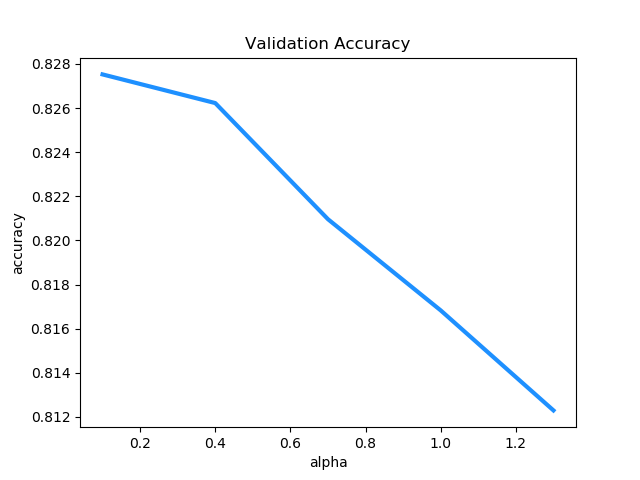

In [297]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(validation_scores.index, validation_scores, lw=3, c='dodgerblue')
ax.set_title('Validation Accuracy')
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')

It seems reasonable based on the validation scores produced to say that $[0.1, 0.45]$ is a good place to make a finer
search for a good value of $\alpha$.

In [298]:
##We generate a new set of alpha values to pass to SGDClassifier
alphas = np.arange(0.1, 0.45, step = 0.05)
validation_scores = pd.Series(np.zeros_like(alphas), index=alphas, name='validation_scores')
validation_scores.index.name = 'alpha'


for alpha in alphas:
    sgd = SGDClassifier(loss='log', alpha=alpha, penalty='l2', max_iter=50, random_state=5)
    sgd.fit(NDTrain, TrainLabels)
    pred = sgd.predict(NDValidation)
    loss = accuracy_score(ValidationLabels, pred)
    validation_scores[alpha] = loss

In [299]:
print(validation_scores)

alpha
0.10    0.827528
0.15    0.827928
0.20    0.828494
0.25    0.828694
0.30    0.827828
0.35    0.826761
0.40    0.826228
Name: validation_scores, dtype: float64


<IPython.core.display.Javascript object>


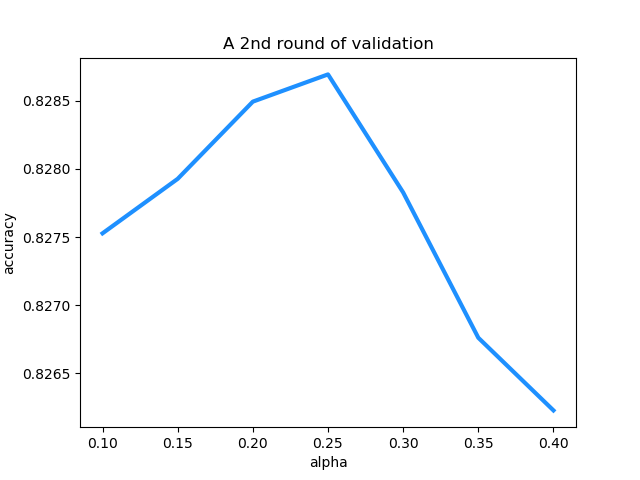

In [300]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(validation_scores.index, validation_scores, lw=3, c='dodgerblue')
ax.set_title('A 2nd round of validation')
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')

Based on the validation scores, we will use $0.25$ as our value for $\alpha$.

Now we want to find a way to create an improved model. A first step to doing this will be to see
how our best classifier learns from the data over time. Our classifier learns by processing the data iteratively, and we can check the training error and the validation error after each iteration has been completed.
We may plot the training error and the validation error as functions of the number of iterations completed. This 
creates the learning curve and by examining it, we may generate ideas for improving performance.


In [301]:
##By using the warm start option on SGDClassifier and setting max_iter to 1 on each call to SGDClassifier,
##we will be able to look at how the learning proceeds from iteration to iteration.
##We will start with looking at 50 iterations. We use the best alpha from the validation process.

##We will initialize a dataframe to hold the data to construct the learning curve

iterations = 50

LearningCurve = pd.DataFrame(np.zeros((iterations,2)), index = np.arange(1,iterations+1), 
                             columns = ['TrainingError', 'ValidationError'])


LearningCurve.index.name = 'Iteration'


for i in range(1, iterations + 1):
    
    if i == 1:
        sgd = SGDClassifier(loss='log', alpha=0.25, penalty='l2', max_iter=1, warm_start=False,
                            random_state=5)
    else:
        sgd = SGDClassifier(loss='log', alpha=0.25, penalty='l2', max_iter=1, warm_start=True,
                            random_state=5)
        

    sgd.fit(NDTrain, TrainLabels)
    training_predictions = sgd.predict(NDTrain)
    validation_predictions = sgd.predict(NDValidation)
    
    LearningCurve.loc[i, 'TrainingError'] =  1 - accuracy_score(TrainLabels, training_predictions)
    LearningCurve.loc[i, 'ValidationError'] =  1 - accuracy_score(ValidationLabels, validation_predictions)
    

<IPython.core.display.Javascript object>


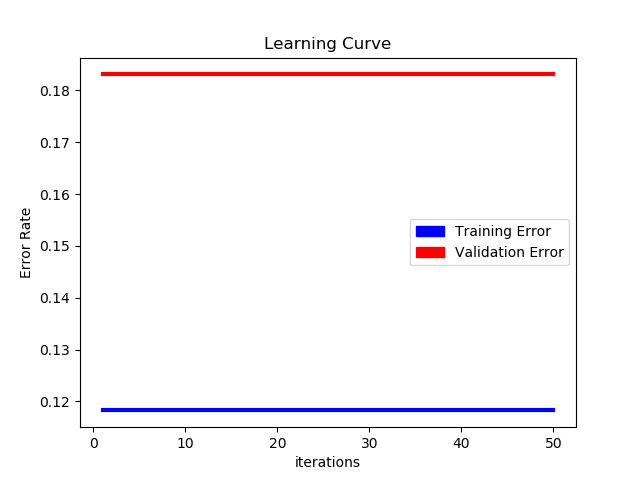

In [302]:
import matplotlib.patches as mpatches

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(LearningCurve.index, LearningCurve.TrainingError, lw=3, c='b')
ax.plot(LearningCurve.index, LearningCurve.ValidationError, lw=3, c='r')
ax.set_title('Learning Curve')
ax.set_xlabel('iterations')
ax.set_ylabel('Error Rate')


blue_patch = mpatches.Patch(color='b', label='Training Error')
red_patch = mpatches.Patch(color='r', label='Validation Error')

ax.legend(handles=[blue_patch, red_patch])



The model doesn't really learn much more from additional iterations. Our model is simple and perhaps not powerful enough to capture the complexity of some of the relations in the data. One possible option at this point is to 
switch to a more complex model. We will instead see if we can improve the performance by exploring other ways of doing feature engineering. We will proceed to try tf-idf weighing instead of using the raw count data.

Tf-idf will take the count data for the words and transform it into what we hope will be a more informative form.
The tf stands for term frequency and the idf stands for inverse document frequency.

Tf-idf will translate the raw count data into weights. In a given document D, if two terms $t_{1}$ and $t_{2}$ occur an equal number of times, and $v_{D}$ is the vector of word counts for D, we will have $(v_{D})_{t_{1}} = (v_{D})_{t_{2}}$. <br><br>
If $tv$ is the same vector after transformation to the tf-idf representation, we will now have
$(tv)_{t_{1}} < (tv)_{t_{2}}$ if it is the case that $t_{1}$ occurred more times in the whole collection than $t_{2}$ did.<br><br>
So tf-idf provides us with a sort of tie-breaker in the feature vectors of reviews. Given two terms that
occurred an equal number of times in a review, we will give more weight and hence more importance to the feature vector component corresponding to the word that occurred less in the entire collection of documents.
Note that we could easily find global word counts by summing across the rows of the raw term-document matrix.

In [303]:
##We can use sklearn's TfidfTransformer object to transform our term-document matrices
##to the tf-idf representation.



tfidf_transformer = TfidfTransformer(norm=None)

TfidfTrain = tfidf_transformer.fit_transform(DTrain)

TfidfValidation = tfidf_transformer.transform(DValidation)


In [304]:
#Normalize variance before SGD
scaler = StandardScaler(with_mean=False)

NTDTrain = scaler.fit_transform(TfidfTrain.astype(float))

NTDValidation = scaler.transform(TfidfValidation.astype(float))


##I will just do a basic grid search over regularization strengths and see
##which value performs best with respect to accuracy

alphas = np.arange(0.1, 2.2, step=0.2)
validation_scores_tf = pd.Series(np.zeros_like(alphas), index=alphas, name='validation_scores_tf')
validation_scores_tf.index.name = 'alpha'

for alpha in alphas:
    sgd = SGDClassifier(loss='log', alpha=alpha, penalty='l2', max_iter=50, random_state=5)
    sgd.fit(NTDTrain, TrainLabels)
    pred = sgd.predict(NTDValidation)
    loss = accuracy_score(ValidationLabels, pred)
    validation_scores_tf[alpha] = loss


In [305]:
print(validation_scores)

alpha
0.10    0.827528
0.15    0.827928
0.20    0.828494
0.25    0.828694
0.30    0.827828
0.35    0.826761
0.40    0.826228
Name: validation_scores, dtype: float64


There is not a notable improvement in performance. In fact, the best performing classifier trained on the tf-idf features is slightly worse than the best classifier trained on the count vectors. Let's still try a finer search for a good hyperparameter value in the region $[0.1, 0.6]$. Perhaps by a more careful hyperparameter optimization, we can get better performance.

In [306]:
##There doesn't seem to really be much improvement
##Lets still make a finer search for the best performing hyperparamter

alphas = np.arange(0.1, 0.45, step=0.04)
validation_scores_tf = pd.Series(np.zeros_like(alphas), index=alphas, name='validation_scores_tf')
validation_scores_tf.index.name = 'alpha'

for alpha in alphas:
    sgd = SGDClassifier(loss='log', alpha=alpha, penalty='l2', max_iter=50, random_state=5)
    sgd.fit(NTDTrain, TrainLabels)
    pred = sgd.predict(NTDValidation)
    loss = accuracy_score(ValidationLabels, pred)
    validation_scores_tf[alpha] = loss



In [307]:
print(validation_scores_tf)

alpha
0.10    0.827528
0.14    0.828028
0.18    0.828528
0.22    0.828961
0.26    0.828561
0.30    0.827828
0.34    0.826961
0.38    0.826128
0.42    0.826361
Name: validation_scores_tf, dtype: float64


Looking at the results, we found a value of the hyperparameter that allowed us to build a best performing classifier that has a slight edge over the best performing classifier trained on the count vectors. We can plot the results of the validation on the count vector data and the results of the validation on the tf-idf data, and we can hopefully  get a better feel for how they compare to each other.

<IPython.core.display.Javascript object>


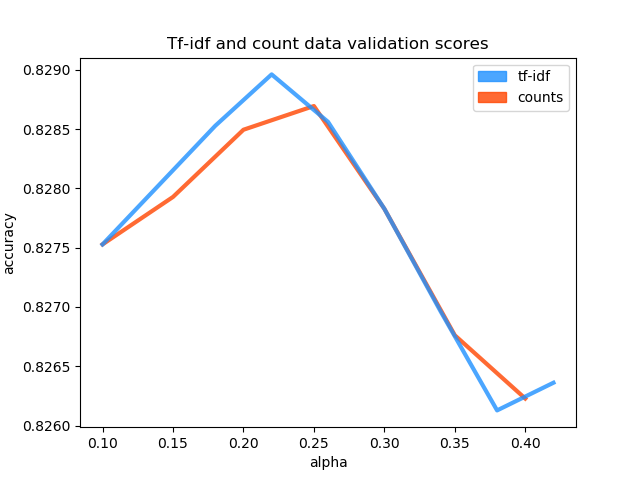

In [308]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(validation_scores.index, validation_scores, lw=3, c='orangered', alpha=0.8)
ax.plot(validation_scores_tf.index, validation_scores_tf, lw=3, c='dodgerblue', alpha=0.8)
ax.set_title('Tf-idf and count data validation scores')
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')

blue_patch = mpatches.Patch(color='dodgerblue', label='tf-idf', alpha=0.8)
red_patch = mpatches.Patch(color='orangered', label='counts', alpha=0.8)

ax.legend(handles=[blue_patch, red_patch])

Examining the validation curves, I think it's reasonable to prefer using the data with the 
tf-idf transformation applied to it. Hopefully, the tf-idf data will allow us to create a more robust classifier whose performance on the test set will be more or less in line with its performance on the validation set.

We will now apply another approach to feature engineering. We will return again to the basic matrix of counts, but this time, we will count occurrences of unigrams and bigrams. A unigram is a single word. So in this new terminology, 
we have previously used the matrix of unigram counts. <br>
<br>A bigram is basically a pair of words being treated as one unit. Similar to how we could look for occurences of a word such as *good* in the documents, we could also look for occurrences of sequences of words like *very good*.

Since we are attempting to separate the 5 star reviews from the rest of the reviews, creating a feature that can distiguish reviews that contained the bigram *very good* versus those that only contained the unigram *good* seems like it should be helpful to our classifier. This is the kind of reasoning that leads us to use bigrams.

The concept of a bigram can be generalized to n-grams, which are sequences of n words that are treated as one unit.
However, the computational overhead will grow quite large as we make n larger, so we will just stick with
n = 1 and n = 2. The notion of a bigram is intuitively appealing, and we expect that it will help to improve the quality of the classifier.



In [309]:
##In practice, will get the bigrams by simply creating a new CountVectorizer object 
##with a different ngram_range value.
BigramCounter = CountVectorizer(max_features=100000, ngram_range=(1,2))

BTrain = BigramCounter.fit_transform(Train)
BValidation = BigramCounter.transform(Validation)

NBTrain = scaler.fit_transform(BTrain.astype(float))

NBValidation = scaler.transform(BValidation.astype(float))

And let's proceed to do some validation.

In [310]:
alphas = np.arange(0.1, 0.5, step=0.04)
validation_scores_b = pd.Series(np.zeros_like(alphas), index=alphas, name='validation_scores_b')
validation_scores_b.index.name = 'alpha'

for alpha in alphas:
    sgd = SGDClassifier(loss='log', alpha=alpha, penalty='l2', max_iter=50, random_state=5)
    sgd.fit(NBTrain, TrainLabels)
    pred = sgd.predict(NBValidation)
    loss = accuracy_score(ValidationLabels, pred)
    validation_scores_b[alpha] = loss

In [311]:
validation_scores_b

alpha
0.10    0.842728
0.14    0.845028
0.18    0.845795
0.22    0.847262
0.26    0.847562
0.30    0.847362
0.34    0.847762
0.38    0.847795
0.42    0.847795
0.46    0.847828
Name: validation_scores_b, dtype: float64

We got improvement across the board. Let's make a plot to make this more clear.

<IPython.core.display.Javascript object>


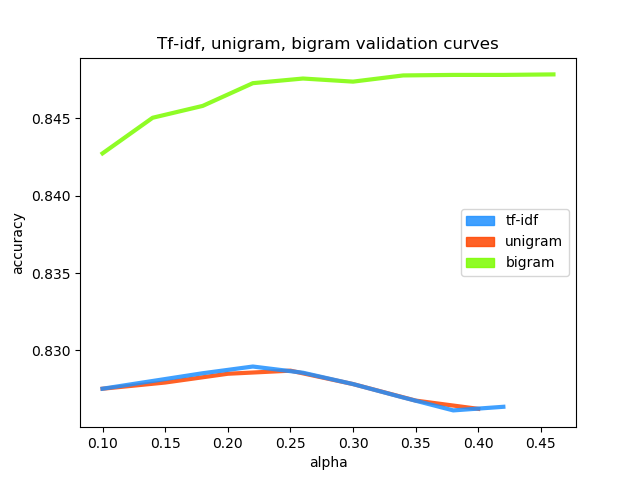

In [312]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(validation_scores.index, validation_scores, lw=3, c='orangered', alpha=0.85)
ax.plot(validation_scores_tf.index, validation_scores_tf, lw=3, c='dodgerblue', alpha=0.85)
ax.plot(validation_scores_b.index, validation_scores_b, lw=3, c='lawngreen', alpha=0.85)
ax.set_title('Tf-idf, unigram, bigram validation curves')
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')

blue_patch = mpatches.Patch(color='dodgerblue', label='tf-idf', alpha=0.85)
red_patch = mpatches.Patch(color='orangered', label='unigram', alpha=0.85)
green_patch = mpatches.Patch(color='lawngreen', label='bigram', alpha=0.85)
ax.legend(handles=[blue_patch, red_patch, green_patch])

So the model trained with  bigram features clearly dominates the other two models. We will finish up by applying the tf-idf transformation to the bigram data, validating, and seeing how  models trained on the tf-idf bigram data compare to the models we trained on the bigram count data. Then, we will take our best performing model and evaluate its performance on the test set.

In [313]:
TBTrain = tfidf_transformer.fit_transform(BTrain)
TBValidation = tfidf_transformer.transform(BValidation)

NTBTrain = scaler.fit_transform(TBTrain.astype(float))
NTBValidation = scaler.transform(TBValidation.astype(float))

In [314]:
alphas = np.arange(0.1, 0.6, step=0.04)
validation_scores_tfb = pd.Series(np.zeros_like(alphas), index=alphas, 
                                  name='validation_scores_tfb')
validation_scores_tfb.index.name = 'alpha'

for alpha in alphas:
    sgd = SGDClassifier(loss='log', alpha=alpha, penalty='l2', max_iter=50, random_state=5)
    sgd.fit(NTBTrain, TrainLabels)
    pred = sgd.predict(NTBValidation)
    loss = accuracy_score(ValidationLabels, pred)
    validation_scores_tfb[alpha] = loss

In [315]:
validation_scores_tfb

alpha
0.10    0.842728
0.14    0.845028
0.18    0.845795
0.22    0.847262
0.26    0.847562
0.30    0.847362
0.34    0.847762
0.38    0.847795
0.42    0.847795
0.46    0.847828
0.50    0.847862
0.54    0.847728
0.58    0.847595
Name: validation_scores_tfb, dtype: float64

<IPython.core.display.Javascript object>


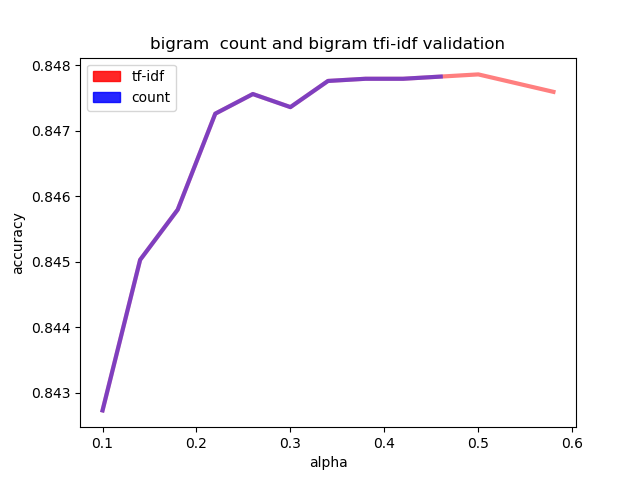

In [316]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(validation_scores_tfb.index, validation_scores_tfb, lw=3, c='red', alpha=0.5)
ax.plot(validation_scores_b.index, validation_scores_b, lw=3, c='blue', alpha=0.5)

ax.set_title('bigram  count and bigram tfi-idf validation')
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')

red_patch = mpatches.Patch(color='red', label='tf-idf', alpha=0.85)
blue_patch = mpatches.Patch(color='blue', label='count', alpha=0.85)

ax.legend(handles=[red_patch, blue_patch])

In this case, the curves followed each other almost exactly. However, since tf-idf provided a more noticeable improvement in the unigram case, I will still use it in the final model.<br>
At this point, it's time to do classification on the test set. I will use bigram data with a tf-idf transformation applied to it. The data will be fed into a regularized logistic regression with a regularization strength $\alpha=0.45$. As before, the model will train iteratively using stochastic gradient descent.

In [317]:
##let's put together the training and validation sets to get back the full training data
Train = np.concatenate([Train, Validation], axis=0)
TrainLabels = np.concatenate([TrainLabels, ValidationLabels])

In [318]:
##Transform data
BTrain = BigramCounter.fit_transform(Train)
BTest = BigramCounter.transform(Test)

TBTrain = tfidf_transformer.fit_transform(BTrain)
TBTest = tfidf_transformer.transform(BTest)

NTBTrain = scaler.fit_transform(TBTrain.astype(float))
NTBTest = scaler.transform(TBTest.astype(float))

In [319]:
sgd = SGDClassifier(loss='log', alpha=0.45, penalty='l2', max_iter=50, random_state=5)
sgd.fit(NTBTrain, TrainLabels)
pred = sgd.predict(NTBTest)
acc = accuracy_score(TestLabels, pred)


In [320]:
acc = accuracy_score(TestLabels, pred)
print('On the test set, we achieved an accuracy of:', acc)


On the test set, we achieved an accuracy of: 0.849928330944


At the end, we achieved an accuracy just a hair under 85%. Let's also evaluate according to
precision and recall to ensure that we did not drastically underperform on one class.



In [322]:
p = precision_score(TestLabels, pred)
r = recall_score(TestLabels, pred)

print("We achieved a recall score of:", r)
print("We achieved a precision score of:", p)



We achieved a recall score of: 0.931378268017
We achieved a precision score of: 0.845553897261


The high recall score indicates that our classifier did an excellent job at correctly labelling the 5-star reviews. Meanwhile, the lower precision score indicates that the classifier did not do quite as well in capturing which reviews were negative; however, the precision score is still quite high, so while the classifier performed better on the class of 5-star reviews, it still did  well on the other class.